In [1]:
import pandas as pd

In [2]:
pd.set_option('display.max_columns', None)
df = pd.read_csv('../dev/fraudTest.csv', index_col=0)
df = df.dropna()
df.head(1)

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,SC,29209,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0


## Load data to neo4j

In [ ]:
from neo4j import GraphDatabase
import pandas as pd
import time
import logging

def create_driver(uri, user, password, timeout=300):
    return GraphDatabase.driver(uri, auth=(user, password), connection_timeout=timeout)

def batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

def retry(operation, attempts=3, wait_time=5):
    for attempt in range(attempts):
        try:
            return operation()
        except Exception as e:
            print(f"Attempt {attempt + 1} failed: {e}")
            if attempt < attempts - 1:
                time.sleep(wait_time)
            else:
                raise

def insert_data_in_neo4j(df, driver):
    with driver.session() as session:

        credit_card_nodes = df[['cc_num', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'dob']].drop_duplicates()
        credit_card_query = """
        UNWIND $rows as row
        MERGE (c:CreditCard {cc_num: row.cc_num})
        SET c.first = row.first, c.last = row.last, c.gender = row.gender, c.street = row.street,
            c.city = row.city, c.state = row.state, c.zip = row.zip, c.lat = row.lat,
            c.long = row.long, c.city_pop = row.city_pop, c.job = row.job, c.dob = row.dob
        """
        retry(lambda: session.run(credit_card_query, {'rows': credit_card_nodes.to_dict('records')}))
        

        merchant_nodes = df[['merchant', 'merch_lat', 'merch_long']].drop_duplicates()
        merchant_query = """
        UNWIND $rows as row
        MERGE (m:Merchant {name: row.merchant})
        SET m.merch_lat = row.merch_lat, m.merch_long = row.merch_long
        """
        for batch_data in batch(merchant_nodes.to_dict('records'), 1000):
            retry(lambda: session.run(merchant_query, {'rows': batch_data}))
        

        transaction_edges = df[['cc_num', 'merchant', 'trans_date_trans_time', 'amt', 'category', 'is_fraud']]
        transaction_query = """
        UNWIND $rows as row
        MATCH (c:CreditCard {cc_num: row.cc_num}), (m:Merchant {name: row.merchant})
        CREATE (c)-[:TRANSACTION {trans_date_trans_time: row.trans_date_trans_time, amt: row.amt, category: row.category, is_fraud: row.is_fraud}]->(m)
        """
        for batch_data in batch(transaction_edges.to_dict('records'), 1000):
            retry(lambda: session.run(transaction_query, {'rows': batch_data}))

uri = "neo4j://localhost:7687"
driver = create_driver(uri, "neo4j", "password")

insert_data_in_neo4j(df, driver)

print("Nodes and edges inserted successfully")

driver.close()


In [5]:
from neo4j import GraphDatabase
def create_driver(uri, user, password, timeout=300):
    return GraphDatabase.driver(uri, auth=(user, password), connection_timeout=timeout)

uri = "neo4j://localhost:7687"
driver = create_driver(uri, "neo4j", "password")

## Extract from neo4j

In [6]:
import pandas as pd

def extract_data_from_neo4j(driver):
    with driver.session() as session:

        cc_query = """
        MATCH (c:CreditCard)
        RETURN c.cc_num AS cc_num, c.city AS city, 
               c.city_pop AS city_pop, c.dob AS dob, 
               c.first AS first, c.gender AS gender,
               c.job AS job, c.last AS last,
               c.lat AS lat, c.long AS long,
               c.state AS state, c.street AS street,
               c.zip AS zip
        """
        credit_card_nodes = pd.DataFrame([dict(record) for record in session.run(cc_query)])
        
        merchant_query = """
        MATCH (m:Merchant)
        RETURN m.name AS merchant, m.merch_lat AS merch_lat, m.merch_long AS merch_long
        """
        merchant_nodes = pd.DataFrame([dict(record) for record in session.run(merchant_query)])
        
        transaction_query = """
        MATCH (c:CreditCard)-[t:TRANSACTION]->(m:Merchant)
        RETURN c.cc_num AS cc_num, m.name AS merchant, t.trans_date_trans_time AS trans_date_trans_time,
               t.amt AS amt, t.category AS category, t.is_fraud AS is_fraud
        """
        transactions = pd.DataFrame([dict(record) for record in session.run(transaction_query)])
        
    return credit_card_nodes, merchant_nodes, transactions

credit_card_nodes, merchant_nodes, transactions = extract_data_from_neo4j(driver)

In [7]:
credit_card_nodes.head(1)

,cc_num,city,city_pop,dob,first,gender,job,last,lat,long,state,street,zip
0,2703186189652095,Moravian Falls,3495,1988-03-09,Jennifer,F,"Psychologist, counselling",Banks,36.0788,-81.1781,NC,561 Perry Cove,28654


In [8]:
merchant_nodes.head(1)

,merchant,merch_lat,merch_long
0,"fraud_Rippin, Kub and Mann",31.164104,-91.01738


In [9]:
transactions.head(1)

,cc_num,merchant,trans_date_trans_time,amt,category,is_fraud
0,502049568400,"fraud_Rippin, Kub and Mann",2019-01-18 01:46:20,2.95,misc_net,0


In [10]:
all_df = transactions.join(credit_card_nodes.set_index('cc_num'), on='cc_num').join(merchant_nodes.set_index('merchant'), on='merchant')
all_df.head(1)

,cc_num,merchant,trans_date_trans_time,amt,category,is_fraud,city,city_pop,dob,first,gender,job,last,lat,long,state,street,zip,merch_lat,merch_long
0,502049568400,"fraud_Rippin, Kub and Mann",2019-01-18 01:46:20,2.95,misc_net,0,Marion,370,1962-02-13,Daniel,M,Health service manager,Melton,41.7918,-72.7188,CT,6157 Nichols Mews,6444,31.164104,-91.01738


In [11]:
all_df = all_df.assign(trans_date_trans_time= list(map(lambda x: pd.to_datetime(x), all_df.trans_date_trans_time)))

In [12]:
df_not_fraud = all_df[all_df['is_fraud'] == 0].sample(frac=0.2, random_state=999)
df_fraud = all_df[all_df['is_fraud'] == 1]
df_undersampled = pd.concat([df_not_fraud, df_fraud])
df_undersampled.shape

(265340, 20)

In [13]:
from sklearn.utils import resample

non_fraud_rows = df_undersampled[df_undersampled['is_fraud'] == 0].copy()
fraud_rows = df_undersampled[df_undersampled['is_fraud'] == 1].copy()
non_fraud_downsampled = resample(
        non_fraud_rows, 
        n_samples=len(fraud_rows), 
        replace=False, 
        random_state=42
    )
balanced_df = pd.concat([fraud_rows, non_fraud_downsampled])
balanced_df = balanced_df.reset_index()
balanced_df.head(1), balanced_df.shape

(   index               cc_num                    merchant  \
 0    111  4536996888716062123  fraud_Rippin, Kub and Mann   
 
   trans_date_trans_time     amt  category  is_fraud      city  city_pop  \
 0   2020-05-06 03:07:40  779.23  misc_net         1  Espanola     18408   
 
           dob   first gender  \
 0  1972-07-18  Nathan      M   
 
                                                  job     last      lat  \
 0  Historic buildings inspector/conservation officer  Mendoza  35.9866   
 
        long state                  street    zip  merch_lat  merch_long  
 0 -106.0654    NM  767 Adam Mill Apt. 115  87533  31.164104   -91.01738  ,
 (15012, 21))

In [14]:
from sklearn.model_selection import train_test_split

balanced_df_train, balanced_df_test = train_test_split(balanced_df, test_size=0.25, random_state=42)
balanced_df_train.shape, balanced_df_test.shape

((11259, 21), (3753, 21))

In [15]:
import numpy as np

n = len(balanced_df)

train_mask = [i in balanced_df_train.index for i in range(n)]
test_mask = [i in balanced_df_test.index for i in range(n)]
train_mask = np.array(train_mask)
test_mask = np.array(test_mask)

Run the below the 1st time you run this notebook. Afterwards it will load the created edge_index needed for the GCN

In [16]:
# def compute_time_difference(group):
#     n = len(group)
#     result = []
#     for i in range(n):
#         for j in range(n):
#             time_difference = abs(group.iloc[i].trans_date_trans_time.value - group.iloc[j].trans_date_trans_time.value)
#             result.append([group.iloc[i].name, group.iloc[j].name, time_difference])
#     return result
# groups = balanced_df.groupby('cc_num')
# edge_index_list = [compute_time_difference(group) for _, group in groups]
# edge_index_list_flat = [item for sublist in edge_index_list for item in sublist]
# edge_index_list_flat_np = np.array(edge_index_list_flat)
# np.save('edge_index_list_flat.npy', edge_index_list_flat_np)

In [17]:
edge_index = np.load('edge_index_list_flat.npy')
edge_index.shape

(41288, 3)

In [18]:
theta = edge_index[:,2].mean()
edge_index = np.load('edge_index_list_flat.npy').astype(np.float64)
edge_index[:,2] = (np.exp(-edge_index[:,2]/theta) != 1)*(np.exp(-edge_index[:,2]/theta))
edge_index = edge_index.tolist()
mean_ = np.array(edge_index)[:,2].mean()
mean_

0.5879068658910387

In [19]:
edge_index[:5]

[[3186.0, 3186.0, 0.0],
 [3186.0, 3607.0, 0.33761861198557613],
 [3607.0, 3186.0, 0.33761861198557613],
 [3607.0, 3607.0, 0.0],
 [2616.0, 2616.0, 0.0]]

In [20]:
import torch
torch.device('mps')

selected_edges = [(int(row[0]), int(row[1])) for row in edge_index if row[2] > mean_]
edge_index_selected = torch.tensor(selected_edges, dtype=torch.long).t()
edge_index_selected.shape

torch.Size([2, 23278])

In [21]:
pd.set_option('display.max_columns', None)
balanced_df.head(1)

,index,cc_num,merchant,trans_date_trans_time,amt,category,is_fraud,city,city_pop,dob,first,gender,job,last,lat,long,state,street,zip,merch_lat,merch_long
0,111,4536996888716062123,"fraud_Rippin, Kub and Mann",2020-05-06 03:07:40,779.23,misc_net,1,Espanola,18408,1972-07-18,Nathan,M,Historic buildings inspector/conservation officer,Mendoza,35.9866,-106.0654,NM,767 Adam Mill Apt. 115,87533,31.164104,-91.01738


In [22]:
category_dummies = pd.get_dummies(balanced_df['category'], drop_first=True)
balanced_df = pd.concat([balanced_df, category_dummies], axis=1)

In [23]:
balanced_df.head(1)

,index,cc_num,merchant,trans_date_trans_time,amt,category,is_fraud,city,city_pop,dob,first,gender,job,last,lat,long,state,street,zip,merch_lat,merch_long,food_dining,gas_transport,grocery_net,grocery_pos,health_fitness,home,kids_pets,misc_net,misc_pos,personal_care,shopping_net,shopping_pos,travel
0,111,4536996888716062123,"fraud_Rippin, Kub and Mann",2020-05-06 03:07:40,779.23,misc_net,1,Espanola,18408,1972-07-18,Nathan,M,Historic buildings inspector/conservation officer,Mendoza,35.9866,-106.0654,NM,767 Adam Mill Apt. 115,87533,31.164104,-91.01738,0,0,0,0,0,0,0,1,0,0,0,0,0


In [24]:
features = balanced_df[['lat', 'long', 'amt', 'merch_lat', 'merch_long', *category_dummies.columns]].values

In [38]:
category_dummies.columns

Index(['food_dining', 'gas_transport', 'grocery_net', 'grocery_pos',
       'health_fitness', 'home', 'kids_pets', 'misc_net', 'misc_pos',
       'personal_care', 'shopping_net', 'shopping_pos', 'travel'],
      dtype='object')

In [25]:
features.shape

(15012, 18)

In [26]:
from torch_geometric.data import Data

x = torch.tensor(features, dtype=torch.float)
y = torch.tensor(balanced_df['is_fraud'],dtype=torch.int64)
data = Data(x=x, edge_index = edge_index_selected, y=y, train_mask = train_mask, test_mask = test_mask)
data

Data(x=[15012, 18], edge_index=[2, 23278], y=[15012], train_mask=[15012], test_mask=[15012])

## GNNPaper model

In [28]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(18, 64)
        self.conv2 = GCNConv(64,32)
        self.conv3 = GCNConv(32,16)
        self.conv4 = GCNConv(16,2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv4(x, edge_index)

        return F.log_softmax(x, dim=1)

In [30]:
model = GCN()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=5e-4)
model.train()
losses = []
for epoch in range(601):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    losses.append(loss.item())
    if epoch % 20 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')
    loss.backward()
    optimizer.step()

Epoch: 0, Loss: 42.002960205078125
Epoch: 20, Loss: 0.6261407136917114
Epoch: 40, Loss: 0.48851659893989563
Epoch: 60, Loss: 0.4643438756465912
Epoch: 80, Loss: 0.4410637319087982
Epoch: 100, Loss: 0.42365044355392456
Epoch: 120, Loss: 0.4067728817462921
Epoch: 140, Loss: 0.4186851978302002
Epoch: 160, Loss: 0.4084852337837219
Epoch: 180, Loss: 0.4082525074481964
Epoch: 200, Loss: 0.3949858248233795
Epoch: 220, Loss: 0.3920055031776428
Epoch: 240, Loss: 0.40215107798576355
Epoch: 260, Loss: 0.3791128098964691
Epoch: 280, Loss: 0.3808738589286804
Epoch: 300, Loss: 0.37671977281570435
Epoch: 320, Loss: 0.3730270266532898
Epoch: 340, Loss: 0.3760174512863159
Epoch: 360, Loss: 0.37602898478507996
Epoch: 380, Loss: 0.3673294484615326
Epoch: 400, Loss: 0.36185553669929504
Epoch: 420, Loss: 0.36592188477516174
Epoch: 440, Loss: 0.3637107014656067
Epoch: 460, Loss: 0.35867902636528015
Epoch: 480, Loss: 0.3573552072048187
Epoch: 500, Loss: 0.35035184025764465
Epoch: 520, Loss: 0.350217163562774

In [31]:
model.eval()

GCN(
  (conv1): GCNConv(18, 64)
  (conv2): GCNConv(64, 32)
  (conv3): GCNConv(32, 16)
  (conv4): GCNConv(16, 2)
)

In [32]:
pred = model(data).argmax(dim=1)
y_test = data.y[data.test_mask]
y_pred = pred[data.test_mask]

Accuracy: 0.8956, Precision: 0.9714, Recall: 0.8147, F1: 0.8862


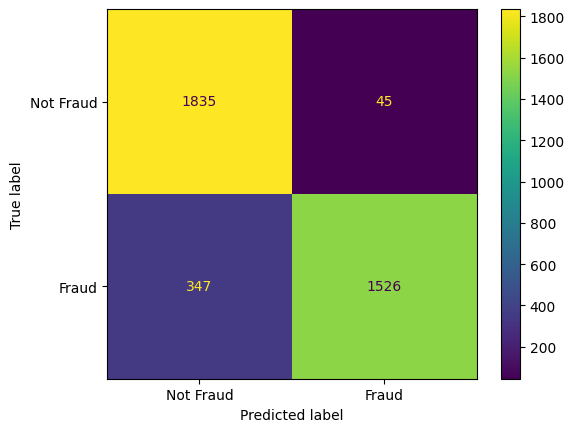

In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = round(accuracy_score(y_test, y_pred), 4)
precision = round(precision_score(y_test, y_pred), 4)
recall = round(recall_score(y_test, y_pred), 4)
f1 = round(f1_score(y_test, y_pred), 4)

print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1: {f1}')

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Fraud', 'Fraud'])
disp.plot()
plt.show()

In [34]:
single_test_case = data.x[data.test_mask][-1].unsqueeze(0)

empty_edge_index = torch.empty((2, 0), dtype=torch.long) 

single_test_data = Data(x=single_test_case, edge_index=empty_edge_index)

In [35]:
single_test_data, data

(Data(x=[1, 18], edge_index=[2, 0]),
 Data(x=[15012, 18], edge_index=[2, 23278], y=[15012], train_mask=[15012], test_mask=[15012]))

In [120]:
model.eval()

with torch.no_grad():
    prediction = model(single_test_data)

predicted_class = prediction.argmax(dim=1).item()

print(f"Predicted class: {predicted_class}")

Predicted class: 0
